In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mcmc_samplers import SGHMCSampler,LossModule
from ResForkNet import *
import utils as ut
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from collections import OrderedDict
import matplotlib.pyplot as plt
import hiddenlayer as hl
from IPython.display import display, clear_output
torch.manual_seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

plt.style.use('ggplot')

cpu


In [2]:
def PearsonCorr(y1, y2):
    v1 = y1 - torch.mean(y1, axis = 0)
    v2 = y2 - torch.mean(y2, axis = 0)
    return torch.sum(v1 * v2, axis = 0) / (torch.sqrt(torch.sum(v1 ** 2, axis = 0)) * torch.sqrt(torch.sum(v2 ** 2, axis= 0)))

def MSE(y1, y2):
    return torch.mean((y1 - y2)**2, axis=0)

def RMSE(y1,y2):
    return torch.sqrt(MSE(y1,y2))

def MAE(y1, y2):
    return torch.mean(torch.abs(y1-y2), axis = 0)

def MAPE(y1, y2):
    return torch.mean(torch.abs(y1-y2) / y1, axis=0)

def compute_statistics(model, path, test_loader, verbose = True):
    model.load_state_dict(torch.load(path,map_location = torch.device(device)))
    model = model.to(device)
    test_data, test_labels, _ = next(iter(test_loader))
    test_data = test_data.to(device)
    test_labels = test_labels.to(device)
    
    with torch.no_grad():
        predicted_labels = model(test_data)
    mse = MSE(test_labels, predicted_labels)
    rmse = RMSE(test_labels, predicted_labels)
    mae = MAE(test_labels, predicted_labels)
    mape = MAPE(test_labels, predicted_labels)
    corr = PearsonCorr(test_labels, predicted_labels)
    
    if verbose:
        for i in range(0, len(stocks),11):
            print("{0:>9}".format("Stocks")+" | ".join(["{0:>9}".format(s) for s in stocks[i:i+11]]))
            print("-"*len(stocks[i:i+11])*13)
            print("{0:>9}".format("MSE")+" | ".join(["{0:>9}".format(round(el,2)) for el in mse.tolist()[i:i+11]]))
            print("-"*len(stocks[i:i+11])*13)
            print("{0:>9}".format("RMSE")+" | ".join(["{0:>9}".format(round(el,2)) for el in rmse.tolist()[i:i+11]]))
            print("-"*len(stocks[i:i+11])*13)
            print("{0:>9}".format("MAE")+" | ".join(["{0:>9}".format(round(el,3)) for el in mae.tolist()[i:i+11]]))
            print("-"*len(stocks[i:i+11])*13)
            print("{0:>9}".format("MAPE")+"% | ".join(["{0:>8}".format(round(el*100,2)) for el in mape.tolist()[i:i+11]])+"%")
            print("-"*len(stocks[i:i+11])*13)
            print("{0:>9}".format("Corr")+" | ".join(["{0:>9}".format(round(el,3)) for el in corr.tolist()[i:i+11]]))
            print("\n\n")
    else: return mse, rmse, mae, mape, corr

In [3]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 7,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, length s)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3837, 60, 330) (3837, 11)
torch.Size([1, 3840])


In [4]:
compute_statistics(model, "Week/model_60_7", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     0.92 |      72.4 |     38.69 |      0.47 |      0.85 |      1.35 |      1.57 |      6.91 |      3.04 |      0.52 |      1.07
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     0.96 |      8.51 |      6.22 |      0.68 |      0.92 |      1.16 |      1.25 |      2.63 |      1.74 |      0.72 |      1.04
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.697 |     5.038 |     4.504 |      0.54 |     0.712 |     0.863 |     0.984 |     1.717 |     1.288 |     0.572 |      0.81
------------

In [6]:
compute_statistics(model, "Week/model_week_7", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     0.93 |     52.67 |     38.11 |      0.55 |      0.98 |       1.5 |      1.51 |      5.75 |      2.95 |      0.46 |      0.93
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     0.97 |      7.26 |      6.17 |      0.74 |      0.99 |      1.23 |      1.23 |       2.4 |      1.72 |      0.68 |      0.96
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.738 |     4.853 |     4.533 |      0.59 |     0.726 |     0.866 |     0.938 |     1.562 |     1.306 |     0.532 |     0.751
------------

In [12]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 14,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3830, 60, 330) (3830, 11)
torch.Size([1, 3840])


In [24]:
compute_statistics(model, "2Weeks/model_2week_9", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.46 |     85.84 |     55.41 |      0.62 |       1.3 |      1.82 |      2.08 |      7.85 |       4.3 |      0.63 |      1.26
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.21 |      9.27 |      7.44 |      0.79 |      1.14 |      1.35 |      1.44 |       2.8 |      2.07 |      0.79 |      1.12
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.924 |     5.822 |     5.168 |     0.621 |     0.875 |     1.013 |     1.115 |     1.841 |     1.535 |     0.608 |     0.876
------------

In [26]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 30,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


In [38]:
compute_statistics(model, "Month/model_month_8", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     0.89 |     59.91 |     47.49 |      0.73 |       1.0 |       1.7 |      2.04 |      7.65 |      3.99 |      0.69 |      1.12
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     0.94 |      7.74 |      6.89 |      0.86 |       1.0 |       1.3 |      1.43 |      2.77 |       2.0 |      0.83 |      1.06
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.725 |     5.079 |      4.92 |     0.684 |     0.777 |     0.984 |     1.101 |     1.787 |     1.447 |     0.646 |      0.83
------------

In [3]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 30,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2, ll_sizes = [10,100,64])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


In [11]:
compute_statistics(model, "ReducedMonth/model_reduced_month8", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE      1.1 |      53.7 |     33.26 |      0.59 |      1.11 |      1.28 |      1.68 |      4.76 |      2.77 |      1.53 |      1.75
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.05 |      7.33 |      5.77 |      0.77 |      1.05 |      1.13 |       1.3 |      2.18 |      1.66 |      1.24 |      1.32
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.797 |     4.406 |     3.913 |     0.599 |     0.806 |     0.841 |     0.985 |     1.509 |     1.266 |     0.985 |     1.032
------------

In [3]:
transform = ut.ToTensor()
stocks =  ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX',
         'EA','NFLX','VZ','ACN','ADBE','AMD','ADI','AKAM','AMAT','CSCO','CTXS','IBM','MSI','ORCL','QCOM','WU']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 30,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2, ll_sizes=[10,100,64])

(3308, 3)


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3308, 60, 810) (3308, 27)
torch.Size([1, 3840])


In [22]:
compute_statistics(model, "Models/model_27stocks_month", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     9.29 |    258.31 |    164.86 |      6.26 |      6.17 |      7.59 |     24.59 |     25.63 |      16.7 |      1.92 |      7.48
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     3.05 |     16.07 |     12.84 |       2.5 |      2.48 |      2.75 |      4.96 |      5.06 |      4.09 |      1.39 |      2.74
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    2.476 |    10.026 |     9.391 |     2.025 |     1.983 |     2.128 |     3.861 |     3.398 |     3.167 |     1.106 |     2.152
------------

In [23]:
compute_statistics(model, "Models/model_27stocks_month1", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     8.35 |    250.13 |    123.71 |      4.39 |      6.57 |      8.35 |      18.2 |     21.42 |     15.88 |      2.54 |      4.42
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.89 |     15.82 |     11.12 |      2.09 |      2.56 |      2.89 |      4.27 |      4.63 |      3.98 |       1.6 |       2.1
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    2.346 |    10.248 |     8.075 |     1.692 |     1.991 |     2.129 |     3.293 |     3.172 |     2.982 |     1.246 |     1.713
------------

In [4]:
compute_statistics(model, "Models/model_27stocks_month2", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     8.45 |    184.56 |     89.82 |      4.26 |      5.83 |      8.32 |     13.63 |     18.29 |     14.85 |      2.02 |      4.43
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.91 |     13.59 |      9.48 |      2.07 |      2.41 |      2.88 |      3.69 |      4.28 |      3.85 |      1.42 |       2.1
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    2.386 |      8.77 |     6.521 |     1.649 |     1.925 |     2.049 |     2.841 |     2.898 |     2.856 |      1.11 |     1.696
------------

In [21]:
compute_statistics(model, "Models/model_27stocks_month3", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     8.65 |    205.62 |     93.17 |      4.07 |      5.97 |     10.35 |      11.3 |     15.75 |     14.64 |      1.94 |      4.62
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.94 |     14.34 |      9.65 |      2.02 |      2.44 |      3.22 |      3.36 |      3.97 |      3.83 |      1.39 |      2.15
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    2.415 |      9.04 |     6.573 |     1.577 |     1.938 |     2.343 |     2.562 |     2.711 |     2.868 |     1.101 |     1.728
------------

In [22]:
compute_statistics(model, "Models/model_27stocks_month4", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     9.08 |    160.09 |     80.44 |      3.76 |      6.03 |       8.0 |      9.38 |     11.59 |      13.3 |      1.97 |      4.36
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     3.01 |     12.65 |      8.97 |      1.94 |      2.46 |      2.83 |      3.06 |       3.4 |      3.65 |       1.4 |      2.09
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE     2.42 |     7.947 |     6.069 |     1.531 |     1.975 |      2.07 |     2.383 |     2.337 |     2.769 |     1.102 |     1.682
------------

In [23]:
compute_statistics(model, "Models/model_27stocks_month5", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE      8.2 |    113.88 |     69.41 |       3.4 |      5.78 |      7.25 |       9.3 |     11.41 |     12.77 |      1.86 |      4.51
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.86 |     10.67 |      8.33 |      1.84 |       2.4 |      2.69 |      3.05 |      3.38 |      3.57 |      1.36 |      2.12
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE     2.34 |     6.788 |     5.765 |     1.451 |     1.929 |     1.987 |     2.313 |     2.399 |      2.68 |      1.09 |     1.687
------------

In [24]:
compute_statistics(model, "Models/model_27stocks_month6", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     8.22 |    106.62 |     68.97 |      3.31 |      5.68 |      7.64 |      8.06 |     11.74 |     13.14 |      1.93 |      4.42
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.87 |     10.33 |       8.3 |      1.82 |      2.38 |      2.76 |      2.84 |      3.43 |      3.62 |      1.39 |       2.1
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    2.351 |     6.803 |     5.784 |     1.406 |     1.925 |     1.995 |     2.143 |     2.353 |     2.717 |     1.108 |     1.676
------------

In [25]:
compute_statistics(model, "Models/model_27stocks_month7", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     8.16 |    109.59 |     54.09 |      3.11 |      5.89 |      7.34 |      7.87 |      9.99 |     13.01 |      1.97 |      4.44
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.86 |     10.47 |      7.35 |      1.76 |      2.43 |      2.71 |      2.81 |      3.16 |      3.61 |       1.4 |      2.11
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE     2.33 |      6.04 |      4.98 |     1.382 |     1.951 |     1.956 |     2.165 |     2.202 |     2.699 |     1.115 |     1.666
------------

In [26]:
compute_statistics(model, "Models/model_27stocks_month8", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     8.32 |     75.79 |     48.02 |      2.82 |      5.87 |      8.21 |      7.36 |      9.12 |     11.03 |      2.12 |      4.44
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.88 |      8.71 |      6.93 |      1.68 |      2.42 |      2.86 |      2.71 |      3.02 |      3.32 |      1.46 |      2.11
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    2.322 |     5.415 |     4.686 |     1.353 |     1.961 |     2.066 |     2.089 |      2.11 |     2.522 |     1.158 |     1.661
------------

# Statistics

In [56]:
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
freq = ["Weekly", "Two-Weekly","Monthly"]
metrics = ["MSE", "RMSE", "MAE", "MAPE", "Corr"]
iterables = [stocks, freq]

multi_idx =  pd.MultiIndex.from_product(iterables, names=["stocks", "metrics"])
stats = pd.DataFrame(0,multi_idx, metrics)

In [58]:
for pred_window, f, path in zip([7,14,30],freq,['Week/model_week_7','2Weeks/model_2week_9','Month/model_month_8']):
    torch.manual_seed(torch.initial_seed())
    transform = ut.ToTensor()
    dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = pred_window,transform = transform)
    lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
    train_set, test_set = torch.utils.data.random_split(dataset, lengths)
    train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                            shuffle=True, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=len(test_set),
                            shuffle=False, num_workers=0)

    model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)
    mse, rmse, mae, mape, corr = compute_statistics(model, path, test_loader, verbose = False)
    mse, rmse, mae, mape, corr = mse.cpu().numpy(), rmse.cpu().numpy(), mae.cpu().numpy(), mape.cpu().numpy(), corr.cpu().numpy()
    stats.loc[pd.IndexSlice[:,f],'MSE'] = mse
    stats.loc[pd.IndexSlice[:,f],'RMSE'] = rmse
    stats.loc[pd.IndexSlice[:,f],'MAE'] = mae
    stats.loc[pd.IndexSlice[:,f],'MAPE'] = mape
    stats.loc[pd.IndexSlice[:,f],'Corr'] = corr

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3837, 60, 330) (3837, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3830, 60, 330) (3830, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


In [59]:
stats

MSE      RMSE       MAE      MAPE      Corr
stocks metrics                                                      
AAPL   Weekly       1.004907  1.002451  0.745195  0.062208  0.999312
       Two-Weekly   1.529416  1.236696  0.928687  0.078743  0.998957
       Monthly      0.997556  0.998777  0.757199  0.066729  0.999395
AMZN   Weekly      65.682556  8.104478  5.165511  0.017723  0.999952
       Two-Weekly  86.292091  9.289353  5.818799  0.020167  0.999937
       Monthly     52.187649  7.224102  4.812568  0.018907  0.999963
GOOGL  Weekly      41.450741  6.438225  4.486129  0.009066  0.999884
       Two-Weekly  57.557877  7.586691  5.375896  0.010762  0.999843
       Monthly     45.652702  6.756679  4.898923  0.010187  0.999897
HPQ    Weekly       0.515550  0.718018  0.569963  0.042729  0.985703
       Two-Weekly   0.701212  0.837384  0.657957  0.048691  0.980145
       Monthly      0.750115  0.866092  0.664347  0.047950  0.981144
INTC   Weekly       0.923190  0.960828  0.743332  0.031900  0.997635
       Two-Weekly   1.453491  1.205608  0.936325  0.040311  0.996365
       Monthly      1.090048  1.044054  0.798392  0.034450  0.997315
MSFT   Weekly       1.424277  1.193431  0.865148  0.022727  0.999740
       Two-Weekly   1.932793  1.390249  1.030398  0.026108  0.999664
       Monthly      1.624355  1.274502  0.963935  0.025371  0.999740
NTAP   Weekly       1.662720  1.289465  0.987549  0.031211  0.995680
       Two-Weekly   2.431257  1.559249  1.183006  0.036343  0.993660
       Monthly      1.995071  1.412470  1.097345  0.033970  0.995370
NVDA   Weekly       7.310040  2.703708  1.779342  0.053370  0.999764
       Two-Weekly   9.212213  3.035163  2.013233  0.060053  0.999718
       Monthly      7.342081  2.709627  1.763313  0.060585  0.999785
SPY    Weekly       2.940339  1.714742  1.300439  0.008880  0.999761
       Two-Weekly   4.565568  2.136719  1.537854  0.010280  0.999634
       Monthly      3.729563  1.931208  1.488426  0.009893  0.999734
T      Weekly       0.463270  0.680639  0.533693  0.024958  0.994775
       Two-Weekly   0.660596  0.812770  0.629453  0.029320  0.992702
       Monthly      0.643012  0.801880  0.623067  0.029072  0.992008
XRX    Weekly       0.946041  0.972646  0.735861  0.033634  0.986091
       Two-Weekly   1.198004  1.094533  0.858033  0.038212  0.983468
       Monthly      1.077811  1.038177  0.822348  0.036364  0.984877

# Error Curves

In [5]:
def compute_metrics(model, path, loader, N):
    model.load_state_dict(torch.load(path,map_location = torch.device(device)))
    model = model.to(device)
    
    mse, rmse, = torch.empty((N,1)),torch.empty((N,1))
    mae, mape = torch.empty((N,1)),torch.empty((N,1))
    corr = torch.empty((N,1))
    for idx, (batch_data, batch_labels) in enumerate(loader, 0):
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        with torch.no_grad():
            predicted_labels = model(batch_data)
 
        mae = torch.cat([mae,torch.unsqueeze(MAE(batch_labels, predicted_labels),dim=1)],axis=1)
        mape = torch.cat([mape,torch.unsqueeze(MAPE(batch_labels, predicted_labels),dim=1)],axis=1)
        
    return mae, mape

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3837, 60, 330) (3837, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3830, 60, 330) (3830, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


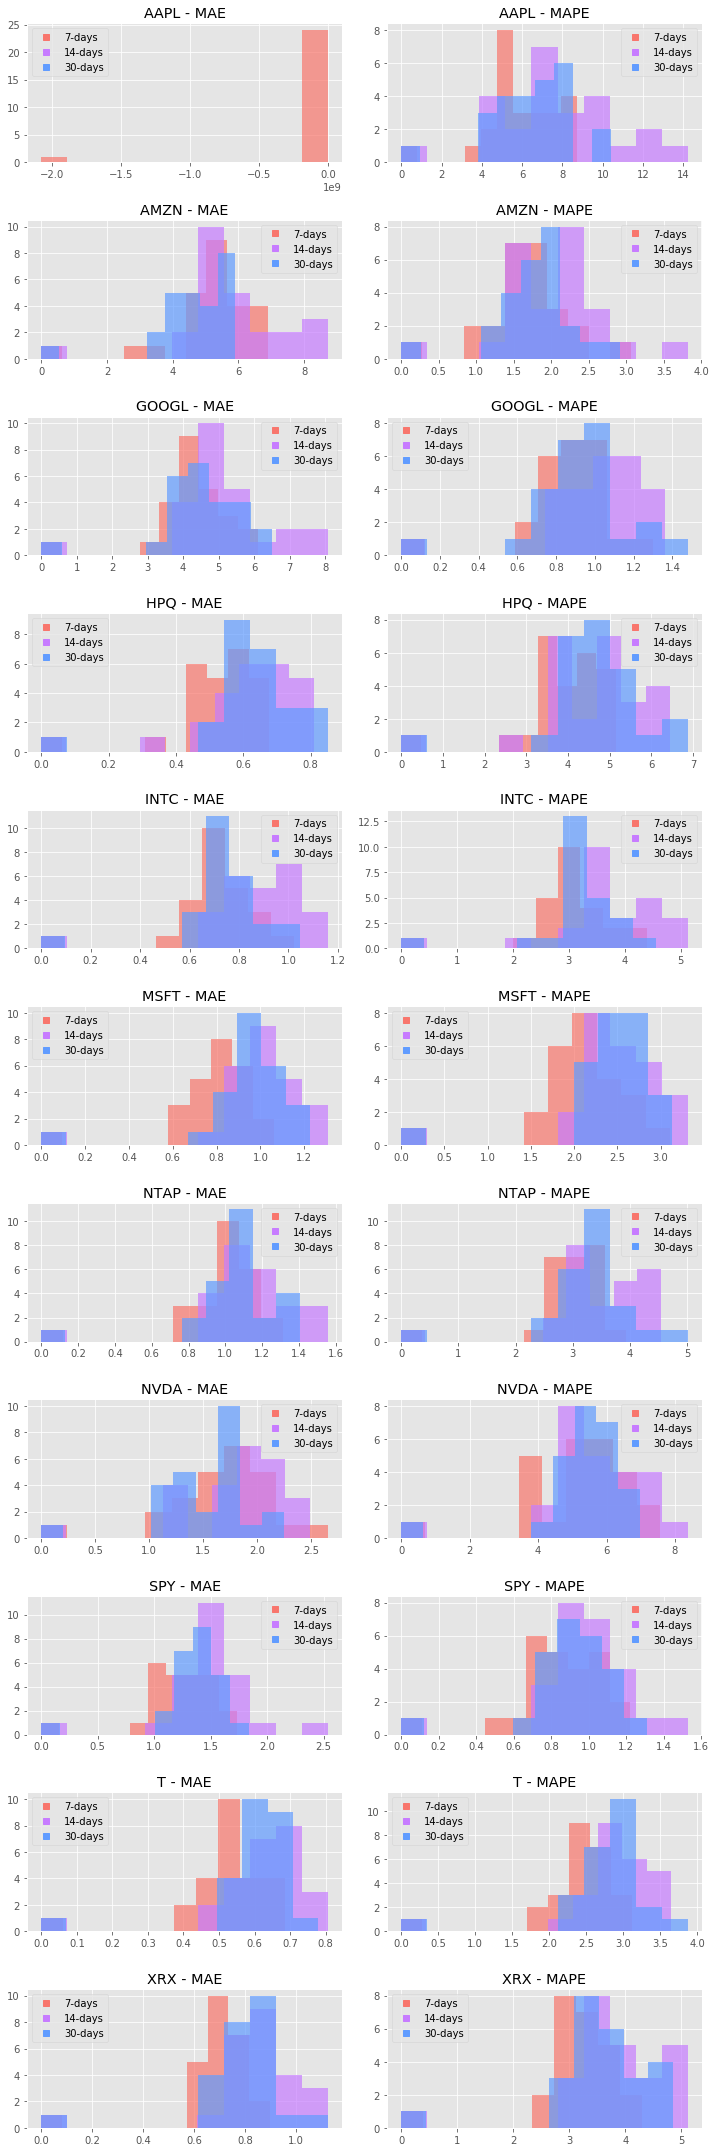

In [12]:
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']

fig, axs = plt.subplots(11,2,figsize=(10,30))
f = lambda ax,m,c: ax.plot([],[],marker=m, color=c, ls="none")[0]
handles = []
for pred_window, path, color in zip([7,14,30],['Week/model_week_7','2Weeks/model_2week_9','Month/model_month_8'],['#F8766D','#C77CFF','#619CFF']):
    torch.manual_seed(torch.initial_seed())
    transform = ut.ToTensor()
    dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = pred_window,transform = transform)
    lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
    train_set, test_set = torch.utils.data.random_split(dataset, lengths)
    train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                            shuffle=True, num_workers=0)
    test_loader = DataLoader(test_set, batch_size= 32,#len(test_set),
                            shuffle=False, num_workers=0)

    model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)
    #mae_tr, mape_tr = compute_metrics(model, path, train_loader, len(stocks))
    #mae_tr, mape_tr = mae_tr.cpu().numpy(), mape_tr.cpu().numpy()
    
    mae_test, mape_test = compute_metrics(model, path, test_loader, len(stocks))
    mae_test, mape_test = mae_test.cpu().numpy(), mape_test.cpu().numpy()
    
    for i in range(len(stocks)):
        axs[i,0].hist(mae_test[i,:], color = color, bins=len(mae_test), alpha = 0.7)
        axs[i,1].hist(mape_test[i,:]*100, color = color, bins=len(mape_test), alpha = 0.7)
    
    
labels = ['7-days','14-days','30-days']
for i,ax in enumerate(axs):
    handles = [f(ax[0],"s",color) for color in ['#F8766D','#C77CFF','#619CFF']]
    ax[0].legend(handles, labels)
    handles = [f(ax[1],"s",color) for color in ['#F8766D','#C77CFF','#619CFF']]
    ax[1].legend(handles, labels)
    ax[0].set_title("{} - MAE".format(stocks[i]))
    ax[1].set_title("{} - MAPE".format(stocks[i]))
plt.tight_layout()
plt.show()

In [2]:
import time
#ss = ['EA','NFLX','VZ','ACN','ADBE','AMD','ADI','AKAM','AMAT','CSCO','CTXS','IBM','MSI','ORCL','QCOM','WU']
ss = ['CSCO','CTXS','IBM','MSI','ORCL','QCOM','WU']
#ss = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
for s in ss:
    print(s)
    ind = ut.getIndicators(symbol = s)
    ind = ind.sort_index(axis=1)
    time.sleep(60)
    price = ut.stockTS(function='TIME_SERIES_DAILY',symbol = s)
    price = price.sort_index(axis=1)
    merged_df = pd.concat([ind,price], axis = 1)
    #merged_df = pd.merge(ind,price, left_index = True, right_index = True)
    merged_df = merged_df.dropna(how='any',axis=0)
    merged_df.columns = list(ind.columns) + list(price.columns)
    print(merged_df.columns)
    merged_df.to_csv('Tech/{}.csv'.format(s))
    time.sleep(60)

CSCO
MOM_14
DEMA_10
DEMA_20
DEMA_50
DEMA_100
APO_None
OBV_None
ROC_14
WMA_10
WMA_20
WMA_50
WMA_100
TRIMA_10
TRIMA_20
TRIMA_50
TRIMA_100
MACD_None
STOCH_None
KAMA_10
KAMA_20
KAMA_50
KAMA_100
CCI_20
BBANDS_10
BBANDS_20
BBANDS_50
BBANDS_100
EMA_10
EMA_20
EMA_50
EMA_100
SMA_10
SMA_20
SMA_50
SMA_100
RSI_14
PPO_None
WILLR_14
CMO_14
AROON_25
ADX_14
MAMA_None
TEMA_10
TEMA_20
TEMA_50
TEMA_100
Index(['ADX_14', 'APO', 'Aroon Down_25', 'Aroon Up_25', 'CCI_20', 'CMO_14',
       'DEMA_10', 'DEMA_100', 'DEMA_20', 'DEMA_50', 'EMA_10', 'EMA_100',
       'EMA_20', 'EMA_50', 'FAMA', 'KAMA_10', 'KAMA_100', 'KAMA_20', 'KAMA_50',
       'MACD', 'MACD_Hist', 'MACD_Signal', 'MAMA', 'MOM_14', 'OBV', 'PPO',
       'ROC_14', 'RSI_14', 'Real Lower Band_10', 'Real Lower Band_100',
       'Real Lower Band_20', 'Real Lower Band_50', 'Real Middle Band_10',
       'Real Middle Band_100', 'Real Middle Band_20', 'Real Middle Band_50',
       'Real Upper Band_10', 'Real Upper Band_100', 'Real Upper Band_20',
       'Real

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline
rc('animation', html='jshtml')
plt.style.use('ggplot')

In [31]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    scatter.set_offsets(np.array([[]]))
    return (line,scatter,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(i, 2+i, 1000)
    y = 2*x
    axs[0].set_xlim(min(x), max(x))
    axs[0].set_ylim(min(y), max(y))
    line.set_data(x, y)
    
    np.random.shuffle(x)
    #np.random.shuffle(y)
    axs[1].set_xlim(min(x), max(x))
    axs[1].set_ylim(min(y), max(y))
    scatter.set_offsets(np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1))
    return (line,scatter,)

# call the animator. blit=True means only re-draw the parts that have changed.
fig, axs = plt.subplots(1,2)
axs[0].grid()
#ax.set_xlim(( 0, 2))
#ax.set_ylim((-2, 2))
line, = axs[0].plot([], [], lw=2)
scatter = axs[1].scatter([], [])
plt.close()
anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=100, interval=500, blit=True)
anim